<a href="https://colab.research.google.com/github/LThomp101/NiyPy2018/blob/main/ForestFire_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing Forest Fire Data**


In [ ]:
%matplotlib inline

import gdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**About the data:**
Predict the burned area of forest fires in the northeast region of Portugal.

The area burned is dependent on other meteorlogical factors in the dataset:
1. month - month of the year: 'jan' to 'dec'
2. day - day of the week: 'mon' to 'sun'
3. FFMC - FFMC index from the FWI system: 18.7 to 96.20 (Fire Weather Index)
4. DMC - DMC index from the FWI system: 1.1 to 291.3 (Duff Moisture Code)
5. DC - DC index from the FWI system: 7.9 to 860.6 (Drought Code)
6. ISI - ISI index from the FWI system: 0.0 to 56.10 (Initial Spread Index)
7. temp - temperature in Celsius degrees: 2.2 to 33.30
8. RH - relative humidity in %: 15.0 to 100
9. wind - wind speed in km/h: 0.40 to 9.40
10. rain - outside rain in mm/m2 : 0.0 to 6.4

# **Reading in and shaping the data:**


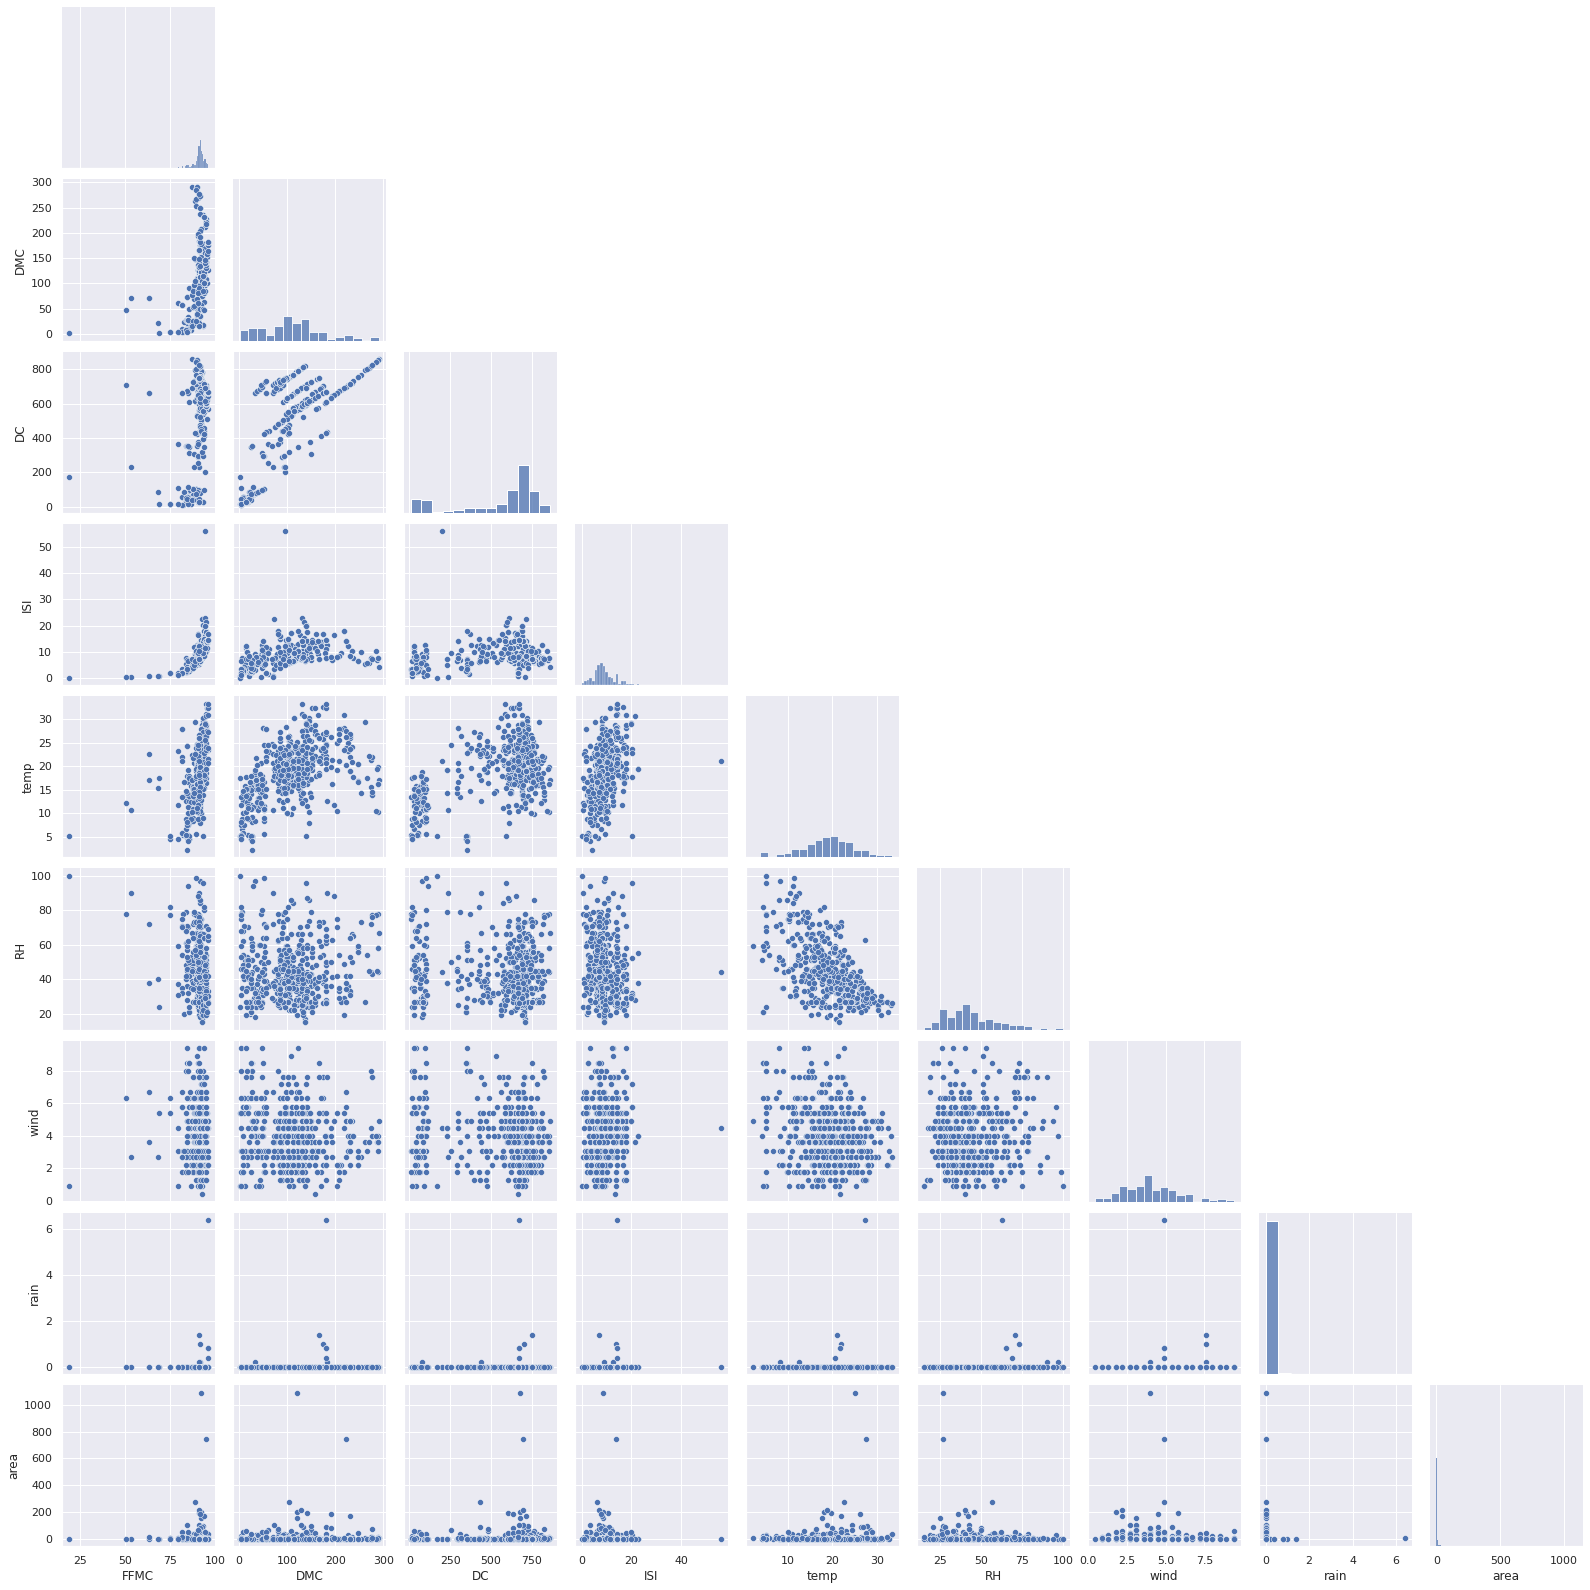

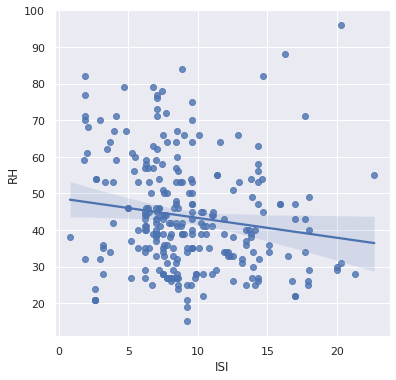

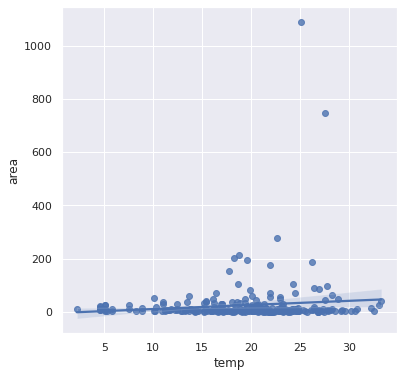

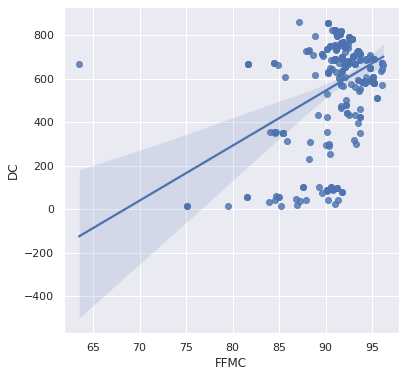

In [ ]:

FFires = pd.read_csv('/content/drive/MyDrive/forestfires.csv')
FFires_all = pd.read_csv('/content/drive/MyDrive/forestfires.csv')

lower_ma = [m.lower() for m in month_abbr]
FFires_all['month'] = FFires_all['month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')
FFires_all=FFires_all.replace(to_replace=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun' ], value=['1', '2', '3', '4', '5', '6', '7'])

# Dropping coordinates columns
FFires = FFires.drop(columns=['X','Y'])
FFires_all = FFires_all.drop(columns=['X', 'Y', 'month', 'day'])
FFires2 = pd.DataFrame(columns=FFires.columns)

# Creating one dataframe with filtered area > 0
cond = FFires.area <= 0
rows = FFires.loc[cond, :]
FFires2 = FFires2.append(rows, ignore_index=True)
FFires.drop(rows.index, inplace=True)


sns.pairplot(FFires_all, corner=True);
plt.figure(figsize=(6,6))
sns.regplot(data = FFires, x='ISI', y='RH');
plt.figure(figsize=(6,6))
sns.regplot(data = FFires, x='temp', y='area');
plt.figure(figsize=(6,6))
sns.regplot(data = FFires, x='FFMC', y='DC');

In [ ]:
FFires_all.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


**The authors transformed the area output with a natural log**

In [ ]:
#Transforming Data
FFires_all['area'] = np.log(1.0 + FFires_all['area'])
FFires['area'] = np.log(1.0 + FFires['area'])
FFires_all.describe()
FFires.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,91.034074,114.707778,570.867037,9.177037,19.311111,43.733333,4.112963,0.028889,2.127409
std,3.709020,61.786520,229.981242,4.147350,6.179444,15.080059,1.884573,0.398392,1.257381
min,63.500000,3.200000,15.300000,0.800000,2.200000,15.000000,0.400000,0.000000,0.086178
25%,90.325000,82.900000,486.500000,6.800000,16.125000,33.000000,2.700000,0.000000,1.144223
50%,91.700000,111.700000,665.600000,8.400000,20.100000,41.000000,4.000000,0.000000,1.997417
75%,92.975000,141.300000,721.325000,11.375000,23.400000,53.000000,4.900000,0.000000,2.798648
max,96.200000,291.300000,860.600000,22.700000,33.300000,96.000000,9.400000,6.400000,6.995620


# **Multilinear Regression:**

In [ ]:

from calendar import month_abbr



# Reading in the variables as x and y
xvars = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
yvar = 'area'

# Breaking up the areas into hetacre bins to analyze fits
yvar_0to5 = FFires.loc[((FFires['area'] >= 0 )) & (FFires['area'] < 5)]
yvar_5to10 = FFires.loc[((FFires['area'] >= 5 )) & (FFires['area'] < 10)]
yvar_10to100 = FFires.loc[((FFires['area'] >= 10 )) & (FFires['area'] <100)]
yvar_10to100 = FFires.loc[(FFires['area'] >= 100)]

# Create and fit the model
model = LinearRegression()
Fitted = model.fit(FFires_all[xvars], FFires_all[yvar])
area_predicted = model.predict(FFires_all[xvars])

# Model Result
area = FFires_all[yvar].to_numpy()
error = area - area_predicted
absolute_e = abs(error)

print('area  predict  error')
print('======  =======  =======')
for i in range(10):
    print(f'{area[i]:6.2f}  {area_predicted[i]:7.2f}  {error[i]:7.2f}')

# R2 of Model Results with all y values
print('Model R^2 = {:.4f}'.format(model.score(FFires_all[xvars], FFires_all[yvar])))

# Assess the Quality of Multilinear Model
print('mean absolute error = {:.4f}'.format(np.mean(np.abs(error))))
print('root mean squared error = {:.4f}'.format(np.sqrt(np.mean(error**2))))

area  predict  error
======  =======  =======
  0.00     1.09    -1.09
  0.00     0.93    -0.93
  0.00     0.96    -0.96
  0.00     0.62    -0.62
  0.00     0.42    -0.42
  0.00     1.13    -1.13
  0.00     1.13    -1.13
  0.00     0.75    -0.75
  0.00     1.22    -1.22
  0.00     1.21    -1.21
Model R^2 = 0.0199
mean absolute error = 1.1404
root mean squared error = 1.3831


# **Confirming the Multilinear Regression Results:**



In [ ]:
# Multilinear Regression
n = len(FFires_all.index)
X = np.array([np.ones(n), FFires_all['FFMC'], FFires_all['DMC'], FFires_all['DC'], FFires_all['ISI'], FFires_all['temp'], FFires_all['RH'], FFires_all['wind'], FFires_all['rain']]).T
y = FFires_all['area']
print(X.shape, y.shape)
print()
a = np.linalg.pinv(X) @ y
print(a)

# Assessing Quality: Ordinary Least Squares
# Positive or Negative relationship with the dependent variable?
import statsmodels.formula.api as sm
result = sm.ols(formula='area ~ FFMC + DMC + DC + ISI + temp + RH + wind + rain', data=FFires_all).fit()

print(result.params)
print()


(517, 9) (517,)

[ 0.22241398  0.0077082   0.00119146  0.0002737  -0.02394939  0.00246183
 -0.00517292  0.07576693  0.09651222]
Intercept    0.222414
FFMC         0.007708
DMC          0.001191
DC           0.000274
ISI         -0.023949
temp         0.002462
RH          -0.005173
wind         0.075767
rain         0.096512
dtype: float64



In [ ]:
y_hat = X @ a
y_abs = np.abs(y-y_hat)

dict = {'Original Response (area)' : y[:9], 'Original Fitted Response (Predicted area)' : y_hat[:9], 'Original Model Error (Abs Error)' : y_abs[:9]}
y_table = pd.DataFrame(dict)
display(y_table)

print()
print()

ybar = np.mean(y)
#print(ybar)
RSS = np.sum((y-y_hat)**2)
#print(RSS)
TSS = np.sum((y-ybar)**2)
#print(TSS)
R2 = 1 - RSS/TSS
print('The R squared value is {0:.4f}'.format(R2))
print()
print()
#print(y_hat[0:9])

,Original Response (area),Original Fitted Response (Predicted area),Original Model Error (Abs Error)
0,0.0,1.085752,1.085752
1,0.0,0.927426,0.927426
2,0.0,0.964123,0.964123
3,0.0,0.615629,0.615629
4,0.0,0.422263,0.422263
5,0.0,1.130803,1.130803
6,0.0,1.126418,1.126418
7,0.0,0.752671,0.752671
8,0.0,1.215573,1.215573




The R squared value is 0.0199




# **Predicted vs. Actual Graph and Unsigned Error:**


The unsinged error in area prediction is 1.1404 +/- 0.7826
Graph represents how well the predicted area matches the actual area.


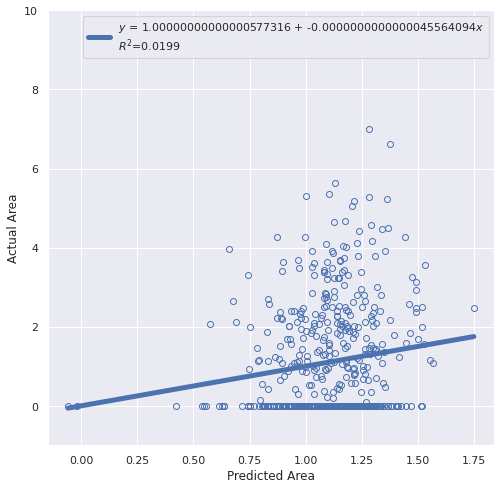

In [ ]:
abs_err = np.abs(y - y_hat)
print('The unsinged error in area prediction is {0:.4f} +/- {1:.4f}'.format(np.mean(abs_err), np.std(abs_err)))


x_line = np.array([np.min(y_hat), np.max(y_hat)])
y_line = e[0] * x_line + e[1]
fit_label = '$y$ = {0:.20f} + {1:.22f}$x$\n$R^2$={2:.4f}'.format(e[0], e[1], R2)
plt.figure(figsize=(8,8))
plt.plot(y_hat, y, 'bo', fillstyle = 'none')
plt.plot(x_line, y_line, 'b-', linewidth = 5, label = fit_label)
plt.xlabel('Predicted Area')
plt.ylabel('Actual Area')

plt.ylim([-1, 10])
plt.legend();

print('Graph represents how well the predicted area matches the actual area.')


# **Assess Distribution of Errors:**

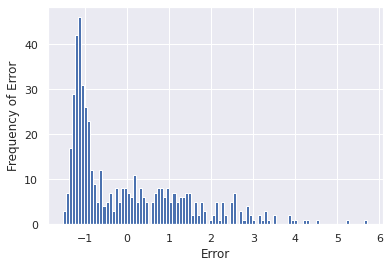

In [ ]:
y_diff = y - y_hat
f = np.polyfit(y_hat, y_diff, deg = 1)
plt.hist(y_diff, bins = 100)
plt.xlabel('Error')
plt.ylabel('Frequency of Error');


# **Which Variable Has the Most Impact on the Area?**

In [ ]:
# multilinear regression for
FFires_all_model2 = LinearRegression()

# make a list of column names to be used in the fit
fit_columns2 = [ 'RH', 'wind', 'rain', 'temp']
print('Columns used for fit:', fit_columns2, '\n')

# fit the model
FFires_all_model2.fit(FFires_all[fit_columns2], FFires_all['area'])
# print the parameters of the fit using Least Squares
print('Fitting coefficients:')
for name, value in zip(fit_columns2, FFires_all_model2.coef_):
    print(f'  {name:8s}   {value:9.6f}')
print()

# get the intercept
intercept = FFires_all_model2.intercept_

# compute R^2 by "scoring" the model
r2 = FFires_all_model2.score(FFires_all[fit_columns2], FFires_all['area'])

# and print the result
print(f'Intercept = {intercept:.4f}\n')
print(f'R^2       = {r2:.4f}')
print(result.summary())


Columns used for fit: ['RH', 'wind', 'rain', 'temp'] 

Fitting coefficients:
  RH         -0.002834
  wind        0.062603
  rain        0.085167
  temp        0.012766

Intercept = 0.7420

R^2       = 0.0104
                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.288
Date:                Mon, 14 Mar 2022   Prob (F-statistic):              0.247
Time:                        20:11:25   Log-Likelihood:                -901.28
No. Observations:                 517   AIC:                             1821.
Df Residuals:                     508   BIC:                             1859.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
 

**Fit Results with Only Observational Data:**

Fitting coefficients:

RH         -0.002834

wind        0.062603

rain        0.085167

temp        0.012766

Intercept_Natural = 0.7420

R^2_Natural       = 0.0104

# **K-Fold Cross Validation:**

Text(0.5, 1.0, 'Training and Testing: Actual vs. Prediction')

<Figure size 432x288 with 0 Axes>

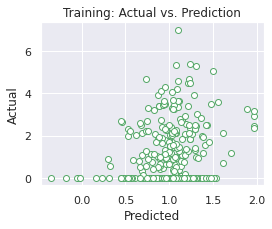

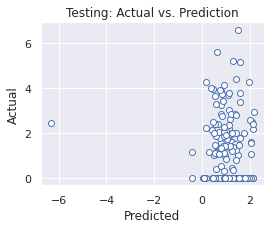

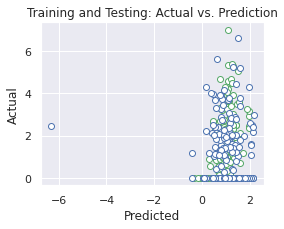

In [ ]:
# K-Fold

# Split data into 70/30
FFires_all_train = FFires_all[:361]
FFires_all_test = FFires_all[361:]

# Turning column names into lists
x_vars = list(FFires_all_train.columns)[0:-1]
y_var = list(FFires_all_train.columns)[-1]

# Fit the model
FFires_all_model2.fit(FFires_all_train[x_vars], FFires_all_train[y_var])

# Take predictions from both sets of data
# If error is similar, model is performing well
y_train_predicted = FFires_all_model2.predict(FFires_all_train[x_vars])
y_test_predicted = FFires_all_model2.predict(FFires_all_test[x_vars])



fig = plt.figure()

# Performance of training set: actual training vs. prediction of training
# Based on the fit of the testing data
plt.figure(figsize=(4,3))
plt.plot(y_train_predicted, FFires_all_train[y_var], 'go', markerfacecolor='white')
plt.title('Training: Actual vs. Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual');


# Performance of testing set: actual testing vs. prediction of testing
# Based on the fit of the training data
plt.figure(figsize=(4,3))
plt.plot(y_test_predicted, FFires_all_test[y_var], 'bo', markerfacecolor='white')
plt.title('Testing: Actual vs. Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual');


plt.figure(figsize=(4,3))
plt.plot(y_train_predicted, FFires_all_train[y_var], 'go', markerfacecolor='white')
plt.plot(y_test_predicted, FFires_all_test[y_var], 'bo', markerfacecolor='white')
plt.xlabel('Predicted')
plt.ylabel('Actual');
plt.title('Training and Testing: Actual vs. Prediction')


# **Undoing Bias with Randomization:**

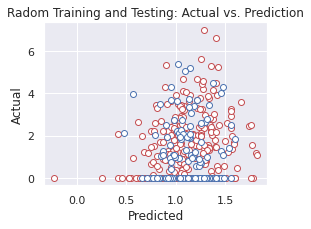

In [ ]:

from sklearn.model_selection import train_test_split

# Split data with Shuffle = True
FFires_all_train_2, FFires_all_test_2 = train_test_split(FFires_all, random_state=12345, shuffle=True)

# Model and Fit
FFires_all_model_2 = LinearRegression()
FFires_all_model_2.fit(FFires_all_train_2[x_vars], FFires_all_train_2[y_var])
y_train_predicted_2 = FFires_all_model_2.predict(FFires_all_train_2[x_vars])
y_test_predicted_2 = FFires_all_model_2.predict(FFires_all_test_2[x_vars])

# Same plot but with randomized instead of sequential split
FFrires_all_train_2, FFires_all_test_2 = train_test_split(FFires_all, random_state=12345, shuffle=True)
plt.figure(figsize=(4,3))
plt.plot(y_train_predicted_2, FFires_all_train_2[y_var], 'ro', markerfacecolor='white')
plt.plot(y_test_predicted_2, FFires_all_test_2[y_var], 'bo', markerfacecolor='white')
plt.title('Radom Training and Testing: Actual vs. Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual');

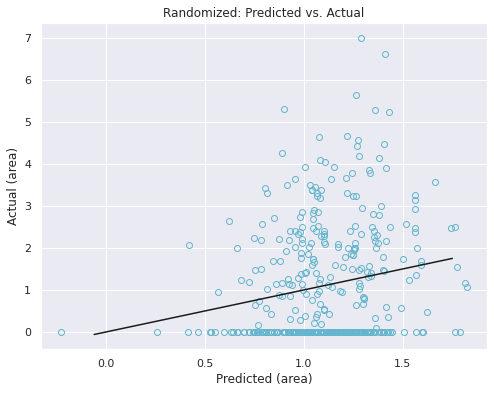

In [ ]:
# Plot Fit Performance
y_predicted_sm = result.fittedvalues
xmin, xmax = np.min(y_predicted_sm), np.max(y_predicted_sm)

plt.figure(figsize=(8,6))
plt.plot(y_train_predicted_2, FFires_all_train_2[y_var], 'co', fillstyle='none')
plt.plot([xmin,xmax], [xmin,xmax], 'k-')
plt.xlabel('Predicted (area)')
plt.title('Randomized: Predicted vs. Actual')
plt.ylabel('Actual (area)');

In [ ]:
# Cross Validation: K-Fold

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold


model = LinearRegression()
k5 = KFold(n_splits=5, shuffle=True, random_state=32525)
mse = []
for train_index, test_index in k5.split(FFires_all):
    X_train, X_test = FFires_all.iloc[train_index,0:7], FFires_all.iloc[test_index,0:7]
    y_train, y_test = FFires_all.iloc[train_index,-1], FFires_all.iloc[test_index,-1]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse.append(np.mean((y_test-y_pred)**2))
print('CV(5) MSE = {:.4f}'.format(np.mean(mse)))



CV(5) MSE = 1.9899


In [ ]:
# Cross Validation: Leave One Out "by hand"

### Columns and Rows Merge
def simple_loo(FFires_all, n_omit):
    left_out = FFires_all[n_omit:n_omit + 1]
    y_actual = left_out.iloc[0,-1]
    fold = FFires_all.drop(n_omit)
    model = LinearRegression()
    xvars = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
    model.fit(fold[xvars], fold['area'])
    y_hat = model.predict(left_out[xvars])
    mse = (y_actual - y_hat)**2
    return mse[0]

# Showing the Mean Standard Error for Each Fold
print('LOO  MSE\n===  =======')
for loo in range(10):
    mse = simple_loo(FFires_all, loo)
    print(f'{loo:3d}  {mse:7.4f}')

#Average of all individual MSEs
loo_mse = []
for loo in range(len(FFires_all)):
    mse = simple_loo(FFires_all, loo)
    loo_mse.append(mse)

print('By Hand: LOO MSE = {:.4f}'.format(np.mean(loo_mse)))


#Double Checking the MSE with the Built-in Functionality
from sklearn.model_selection import LeaveOneOut

def getLOOMSE(FFires_all):
    loo = LeaveOneOut()
    mse = []
    for train_index, test_index in loo.split(FFires_all):
        X_train, X_test = FFires_all.iloc[train_index,0:-1].to_numpy(), FFires_all.iloc[test_index,0:-1].to_numpy()
        y_train, y_test = FFires_all.iloc[train_index,-1].to_numpy(), FFires_all.iloc[test_index,-1].to_numpy()
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        mse.append((y_test[0] - y_predict[0])**2)
    return mse

loo_mse = getLOOMSE(FFires_all)
print('Function: LOO MSE = {:.4f}'.format(np.mean(loo_mse)))
print('MSE is a measure of how far the sample mean is likely to fall from the population mean or, how closely the sample estimate the population.')

LOO  MSE
===  =======
  0   1.2103
  1   0.8898
  2   0.9662
  3   0.4110
  4   0.1959
  5   1.3002
  6   1.2840
  7   0.5957
  8   1.5045
  9   1.4969
By Hand: LOO MSE = 2.0807
Function: LOO MSE = 2.0807
MSE is a measure of how far the sample mean is likely to fall from the population mean or, how closely the sample estimate the population.


**Conclusions**

R^2       = 0.0199

mean absolute error = 1.1404

root mean squared error = 1.3831

K-Fold CV(5) MSE = 1.9899
By Hand: LOO MSE = 2.0807

The error is greater for the LOO method, which is understandable considering it is known for having more variance.


Multilinear regression is not the way to analyze the data as the model does not fit the data well.

Additionally, there may be other variables that better determine the amount of area burned. These variables are not included in the dataset.

